# BSVClassifier Class

In [27]:
import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier

# Analysis

In [28]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, confusion_matrix, accuracy_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from tqdm.notebook import tqdm
import numpy as np

plt.rcParams["figure.figsize"] = (15,4)

Proviamo a generare un dataset artificiale, composto per la 90% da ADL (y=0) e di un 10% da falls (y=1).
Teniamo clusters particolarmente separati

In [29]:
X, y = make_blobs(n_samples=[90, 10], n_features=2, centers=None, cluster_std=1)

In [30]:
print(f'ADL {len(y)-sum(y)} Falls {sum(y)}')

ADL 90 Falls 10


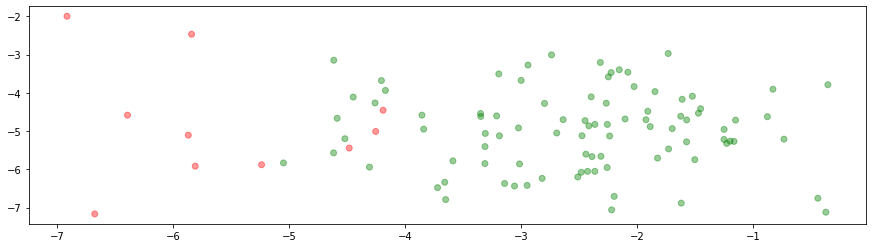

In [31]:
colors = ['green' if i == 0 else 'red' for i in y]

plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=.4)
plt.show()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, shuffle=True)

Verifichiamo che in training vengano visti anche degli outliers (dovrebbe essere già garantito dallo stratify qui sopra)

In [33]:
print(f'{sum(y_train)}/{len(y_train)}')

7/75


Calcoliamo empiricamente i migliori iper parametri tramite una randomized search.

Per definizione C deve stare tra 0 e 1. (1 non è ammissibile, in quanto non permette la presenza di bsv).

Q può essere arbitrariamente grande, così come la penalizzazione.

In [34]:
max_distance = 0
for i in X_train:
    for j in X_train:
        dist = np.linalg.norm(i-j, ord=2)
        if dist > max_distance:
            max_distance = dist

print(f'Max distance {max_distance}')

Max distance 8.03627554104422


Analizziamo il miglior classifier trovato dalla random research

In [35]:
from joblib import dump, load
clf = load('bsv.joblib')

y_pred = clf.predict(X_test)

print(f'Precision {precision_score(y_test, y_pred)}')
print(f'Recall {recall_score(y_test, y_pred)}')
print(f'F1 {f1_score(y_test, y_pred)}')
print(f'Accuracy {accuracy_score(y_test, y_pred)}')

Precision 0.12
Recall 1.0
F1 0.21428571428571425
Accuracy 0.12


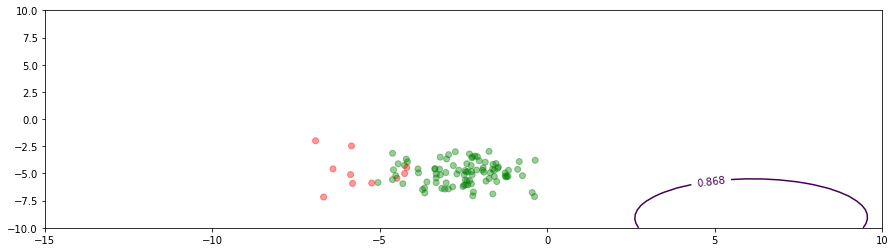

In [36]:
colors = ['green' if i == 0 else 'red' for i in y]

gx = np.linspace(-15, 10, 50)
gy = np.linspace(-10, 10, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radiuses_[clf.sv_i], ))
plt.clabel(membership_contour, inline=1)

plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=.4)

plt.show()

Dal grafico qui sopra dovrebbero risultare tutti e soli i punti verdi inclusi nel contorno.

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f'TP: {tp} FP: {fp} FN: {fn} TN: {tn}')

TP: 3 FP: 22 FN: 0 TN: 0


In [38]:
outliers_ix = [i for i, y in enumerate(clf.y_) if y == 1]

Qui sotto possiamo vedere la distribuzione dei valori di beta. Le beta degli outlier dovrebbero essere sovrapposte ai punti rappresentanti c.
Inoltre il support vector dovrebbe trovarsi abbastanza vicino alla parte centrale del grafico.

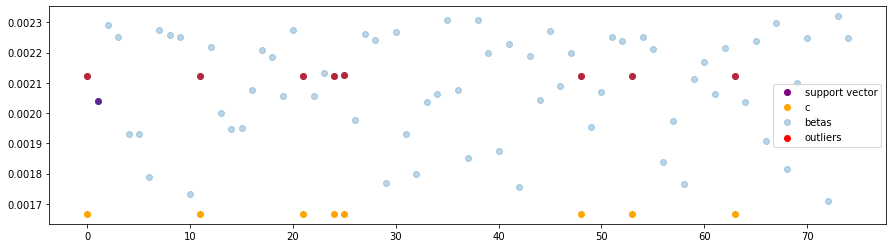

In [39]:
plt.plot(clf.sv_i, clf.betas_[clf.sv_i], 'o', c='purple', label = 'support vector', alpha=1)
plt.plot(outliers_ix, [clf.c]*len(outliers_ix), 'o', c='orange', label = 'c', alpha=1)
plt.scatter(outliers_ix, [clf.betas_[i] for i in outliers_ix], c='red', label='outliers', alpha=1)
plt.plot(clf.betas_, 'o', alpha=.3, label='betas')
plt.legend()
plt.show()

In [40]:
print(f'Sum betas {sum(clf.betas_)} Negative betas {len([1 for b in clf.betas_ if b < 0])}')

Sum betas 0.15661636004395424 Negative betas 0


I raggi degli outlier dovrebbero essere tutti chiaramente sopra a quelli del support vector. Inoltre gli altri dovrebbero essere simili o chiaramente sotto

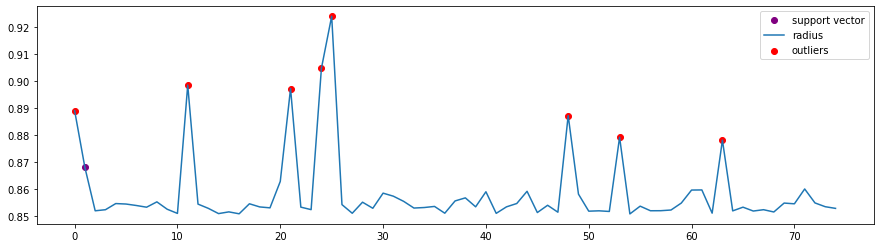

In [41]:
plt.plot(clf.sv_i, clf.radiuses_[clf.sv_i], 'o', c='purple', label = 'support vector', alpha=1)
plt.scatter(outliers_ix, [clf.radiuses_[i] for i in outliers_ix], c='red', label='outliers', alpha=1)
plt.plot(clf.radiuses_, label='radius')
plt.legend()
plt.show()

Proviamo a salvare il modello per fare analisi in un momento successivo

In [42]:
#from joblib import dump, load
#dump(clf, 'bsv.joblib') 